In [188]:
import sys
import math
sys.path.insert(0, '../../..')
from metrics import evaluate_classification
from plots import plot_decision_boundary, plot_data

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [189]:
class NeuralNet:
    def __init__(self, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 30000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0
    
    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches


    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __softmax(self, Z):
        exp_z = np.exp(Z)
        A = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        cache = Z

        return A, cache
    
    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __linear_forward(self, A, W, b):
        Z = W.dot(A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))
    
        return Z, cache

    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, keep_prob=1):
        caches = []
        A = X
        L = len(self.parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def __softmax_backward(self, Y, cache):
        Z = cache
        dZ = Z - Y

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(Z, 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db

    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(Y, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
    
    def __update_parameters(self, grads):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * grads["db" + str(l+1)]

        
    def fit(self, X_vert, Y_vert, X_vert_test, Y_vert_test, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        X_test, Y_test = X_vert_test.T, Y_vert_test.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.keep_prob)

                cost_total += self.compute_cost(AL, minibatch_Y)

                AL_test, _ = self.__forward_propagation(X_test, self.keep_prob)
                val_cost_total += self.compute_cost(AL_test, Y_test)

                grads = self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                self.__update_parameters(grads)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total / m

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            if self.epochs_without_improvement >= self.patience:
                print(f"Early stopping after {i} epochs.")
                break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    

    ### ???
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X)
    
        if self.layer_activations[-1] == 'sigmoid':
            result = np.column_stack((1 - probs.T, probs.T))
        elif self.layer_activations[-1] == 'softmax':
            result = np.column_stack((1 - probs, probs))
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    ### ???
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 1].T
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs , axis=1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result


# Симульовані дані 1

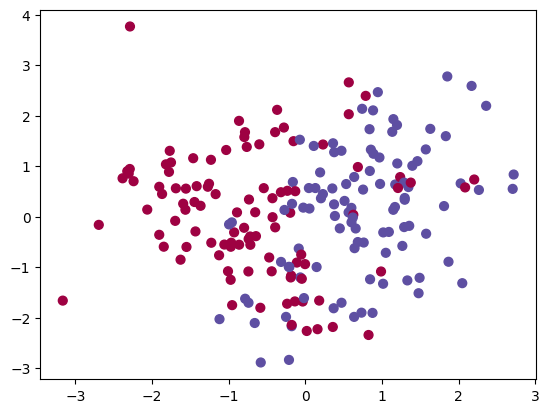

0-th iteration: 0.022053895628856575
1000-th iteration: 0.01845419171568481
Early stopping after 1763 epochs.


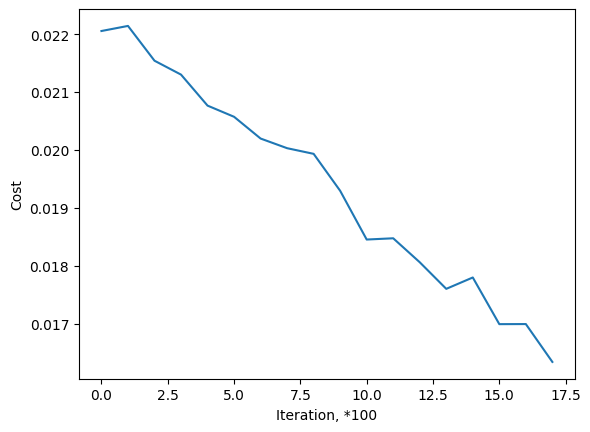

Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        22
           1       0.80      0.89      0.84        18

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40

Confusion: 
    0   1
0  18   4
1   2  16


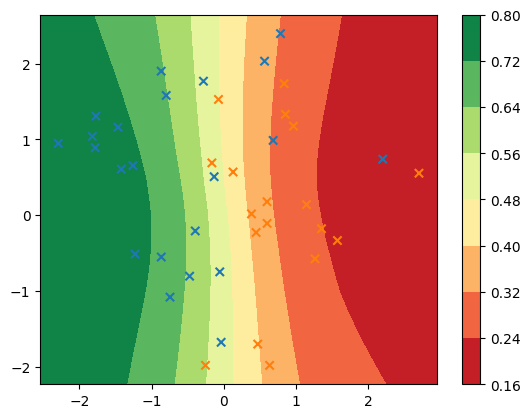

In [190]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LAST_NEURON = 1

# 2 'softmax'

layer_dims_1 = [X.shape[1], 20, 20, 20, 1]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid']
mini_batch_size_1 = 32
keep_prob_1 = 0.9
patience_1 = 100

nn = NeuralNet(layer_dims_1, layer_activations_1, mini_batch_size=mini_batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

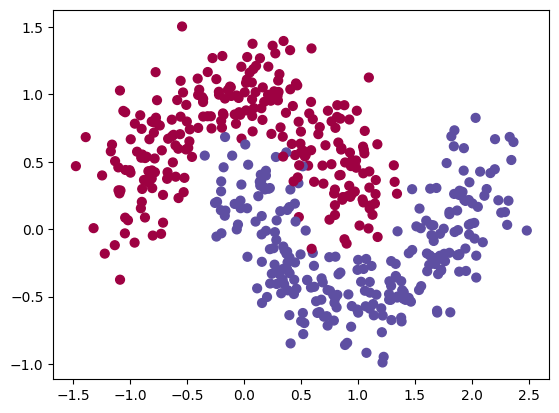

0-th iteration: 0.023049971359596886
1000-th iteration: 0.01130571960674748
2000-th iteration: 0.009272157331712912
3000-th iteration: 0.00805661181281408
4000-th iteration: 0.007213998029275723
Early stopping after 4900 epochs.


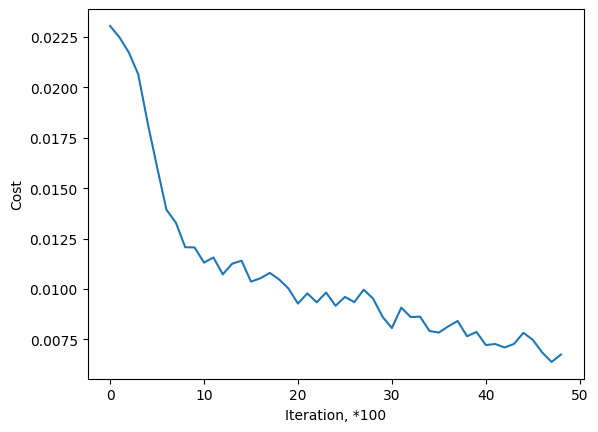

Accuracy: 
0.96
Report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        43
           1       1.00      0.93      0.96        57

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Confusion: 
    0   1
0  43   0
1   4  53


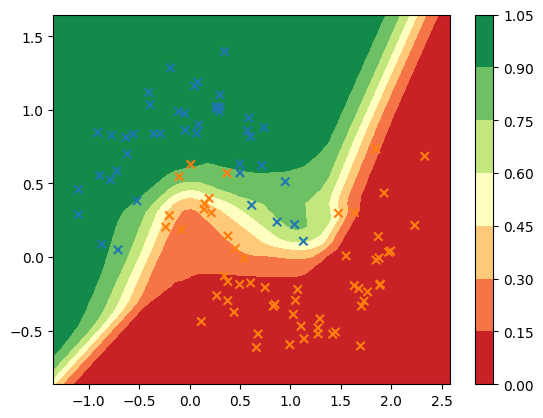

In [191]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_2 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_2 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_2 = 32
keep_prob_2 = 0.9
patience_2 = 2000

nn = NeuralNet(layer_dims_2, layer_activations_2, mini_batch_size=mini_batch_size_2, keep_prob=keep_prob_2, patience=patience_2, learning_rate = 0.001, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

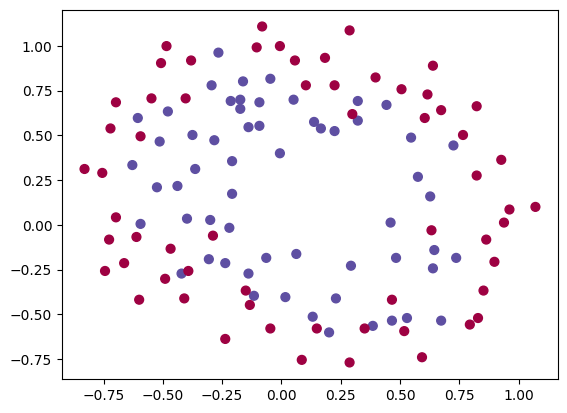

In [192]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0-th iteration: 0.02146600196446272
1000-th iteration: 0.020229455364449627
Early stopping after 1060 epochs.


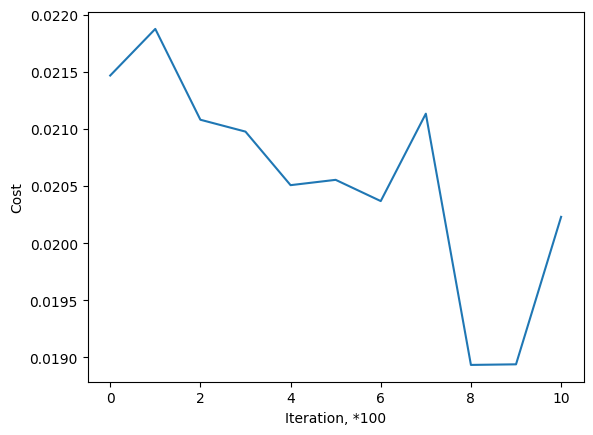

Accuracy: 
0.7083333333333334
Report: 
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.69      0.75      0.72        12

    accuracy                           0.71        24
   macro avg       0.71      0.71      0.71        24
weighted avg       0.71      0.71      0.71        24

Confusion: 
   0  1
0  8  4
1  3  9


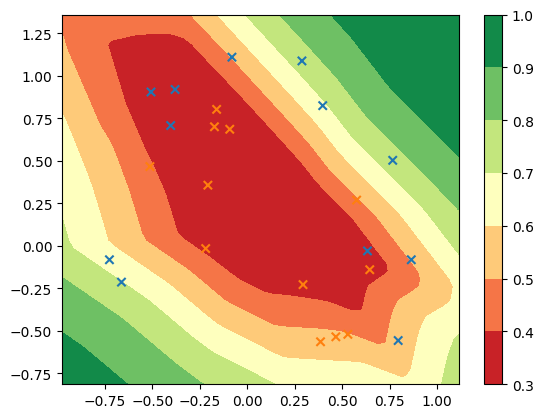

In [193]:
layer_dims_3 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_3 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_3 = 32
keep_prob_3 = 0.9
patience_3 = 500

nn = NeuralNet(layer_dims_3, layer_activations_3, mini_batch_size=mini_batch_size_3, keep_prob=keep_prob_3, patience=patience_3, normalize = True, learning_rate = 0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [194]:
print(nn.parameters)

{'W1': array([[ 0.3783346 , -0.13409456],
       [ 0.57699281,  1.11558063],
       [-0.1478459 , -0.10396983],
       [ 1.10647851,  0.59398533],
       [-0.26565158,  0.19224334],
       [-0.3754455 , -0.36787707],
       [ 0.15672589, -1.41692999],
       [-1.30152324, -0.29985642],
       [-0.77896918,  0.21614839],
       [-0.65607701, -1.02012995]]), 'b1': array([[-0.10743306],
       [-0.09953785],
       [ 0.0149389 ],
       [-0.25786937],
       [ 0.09221316],
       [-0.03426782],
       [-0.16011634],
       [-0.09621628],
       [-0.01175754],
       [ 0.00873821]]), 'W2': array([[ 0.45543626, -0.08077933,  0.02079595, -0.45172564, -0.17153315,
         0.03243761, -0.36594285,  0.1195285 , -0.18998358, -0.10240488],
       [-0.18516195,  0.59139825, -0.00459771, -0.31873702,  0.25301381,
        -0.38636631,  0.07500043, -0.62050668, -0.42222488,  0.0635567 ],
       [ 0.22936154,  0.04038756, -0.03539984, -0.099194  , -0.46691366,
        -0.22432876, -0.14433003,  0.341

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
   0  1
0  9  3
1  3  9


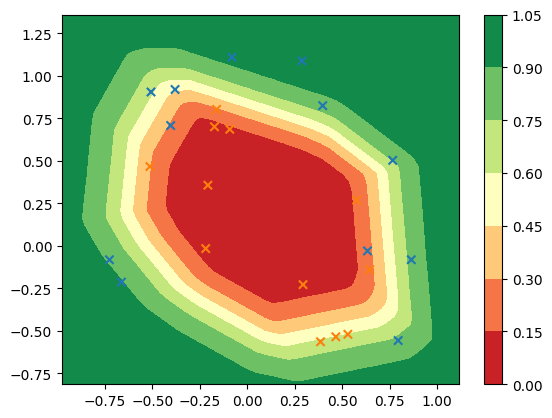

In [195]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [196]:
clf.n_iter_

1792